In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pmdarima as pm
import glob
import holidays
import datetime as dt
from holidays import country_holidays

In [2]:
csv_files = glob.glob('*.csv')

# Create an empty list to store DataFrames
dfs = []

# Loop through each CSV file
for csv_file in csv_files:
    # Read CSV into a DataFrame
    df = pd.read_csv(csv_file)
    # Append DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

In [3]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()

    return fig

In [5]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [6]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [7]:
combined_df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
7713104,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
7713105,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
7713106,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
7713107,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [8]:
combined_df.columns

Index(['ID', 'Date', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Latitude',
       'Longitude'],
      dtype='object')

In [9]:
column2keep = ['ID','Date','Primary Type','Arrest','Domestic','Ward']
df = combined_df[column2keep].copy()  
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%d/%m/%Y %I:%M:%S %p')
df.set_index('Date', inplace=True)
df_ts = df.groupby('Primary Type').resample("M").size()

In [10]:
df_ts.isna().sum()

0

In [11]:
unstacked = df_ts.unstack(level=0)
unstacked

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-31,32.0,1119.0,3230.0,815.0,NaN,155.0,2038.0,9.0,413.0,818.0,...,1525.0,175.0,NaN,96.0,NaN,671.0,229.0,11.0,4411.0,172.0
2001-02-28,38.0,1134.0,3057.0,801.0,NaN,68.0,1936.0,0.0,463.0,520.0,...,1008.0,166.0,NaN,79.0,1.0,597.0,82.0,3.0,3079.0,147.0
2001-03-31,37.0,1035.0,3098.0,844.0,NaN,63.0,1795.0,1.0,443.0,465.0,...,1007.0,156.0,NaN,85.0,0.0,653.0,66.0,11.0,3077.0,147.0
2001-04-30,25.0,991.0,3255.0,787.0,NaN,58.0,1890.0,0.0,436.0,434.0,...,1007.0,171.0,NaN,95.0,0.0,654.0,71.0,4.0,3073.0,138.0
2001-05-31,39.0,1082.0,2944.0,823.0,NaN,52.0,1809.0,3.0,431.0,529.0,...,1020.0,176.0,NaN,77.0,0.0,611.0,82.0,7.0,3289.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,23.0,659.0,1218.0,279.0,8.0,NaN,816.0,34.0,153.0,544.0,...,479.0,4.0,0.0,17.0,NaN,282.0,28.0,18.0,1835.0,246.0
2022-09-30,9.0,701.0,1310.0,222.0,4.0,NaN,825.0,42.0,133.0,467.0,...,451.0,11.0,1.0,16.0,NaN,270.0,44.0,11.0,1734.0,272.0
2022-10-31,10.0,666.0,1424.0,242.0,4.0,NaN,923.0,51.0,145.0,529.0,...,478.0,0.0,NaN,16.0,NaN,338.0,38.0,16.0,1873.0,274.0


In [12]:
unstacked = unstacked.interpolate()

In [13]:
assault = unstacked['ASSAULT']
theft = unstacked['THEFT']

# Assault

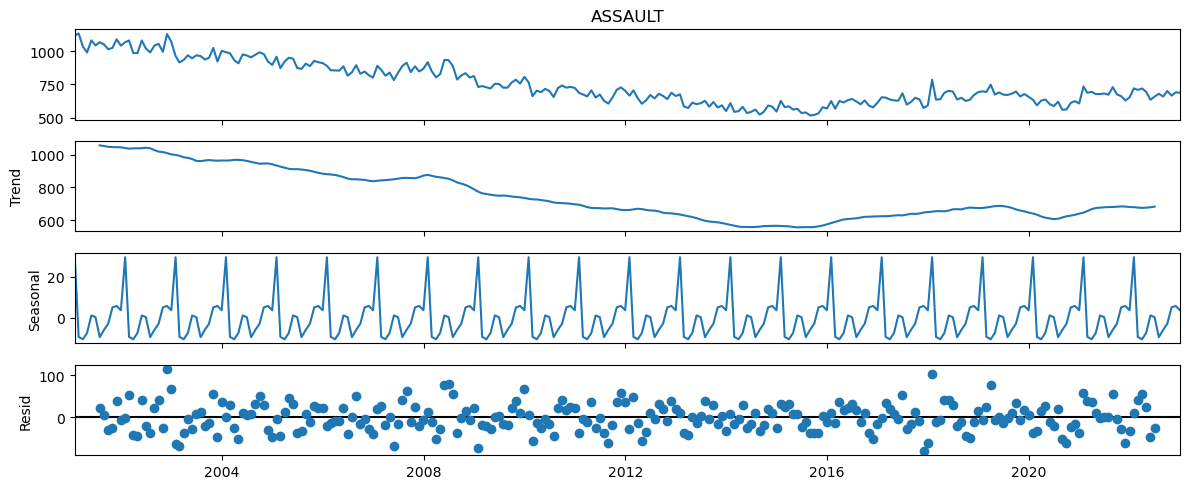

In [14]:
assault_decomp = tsa.seasonal_decompose(assault)
fig = assault_decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [15]:
assault_seasonal_delta = assault_decomp.seasonal.max() - assault_decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {assault_seasonal_delta} which is ~{assault_seasonal_delta/(assault.max()-assault.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 40.099206349206355 which is ~6.50% of the variation in time series.


In [16]:
d = ndiffs(assault)
D = nsdiffs(assault,m=12)
print (f'd = {d}')
print (f'D = {D}')

d = 1
D = 0


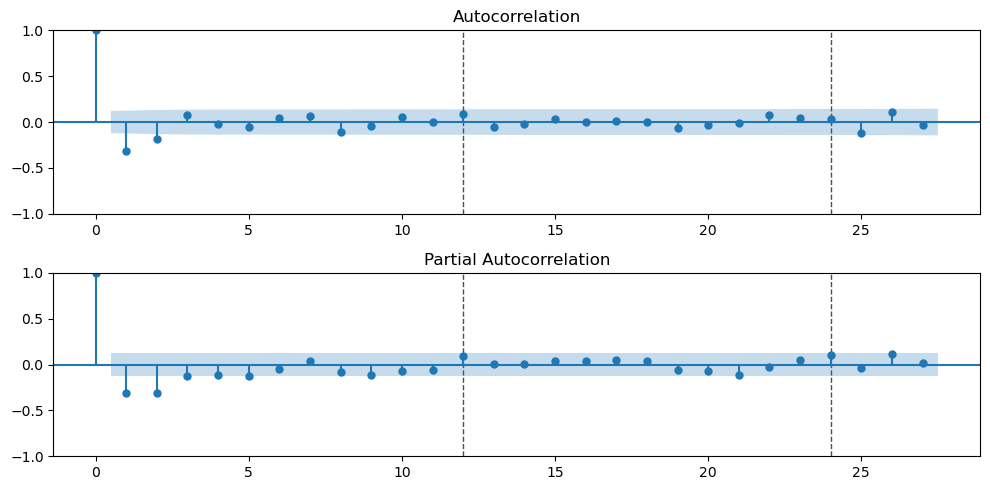

In [17]:
assault_diff = assault.diff().dropna()
plot_acf_pacf(assault_diff, annotate_seas=True, m = 12, nlags = 27);

the seasonal part represent 6.50% of the variation of the data .

ACF seems to drop after the first lag . 

PACF seems to drop after the second lag .

let's try ARMA(2,1,1)

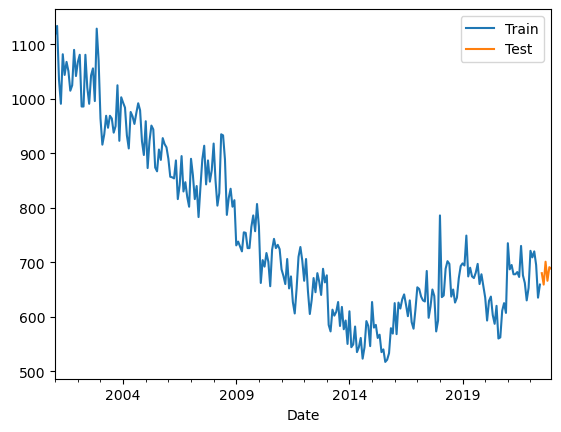

In [18]:
train_assault, test_assault = train_test_split(assault, test_size= 6)
ax = train_assault.plot(label='Train')
test_assault.plot(ax=ax, label='Test')
ax.legend();

In [19]:
p=2
d=1
q=1
P=0
D=0
Q=0
m=12
assault_model = tsa.ARIMA(
    train_assault, order=(p,d,q)
).fit()
assault_model.summary()

C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ASSAULT   No. Observations:                  258
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1312.243
Date:                Tue, 12 Mar 2024   AIC                           2632.485
Time:                        19:42:53   BIC                           2646.681
Sample:                    01-31-2001   HQIC                          2638.194
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1741      0.129      1.353      0.176      -0.078       0.426
ar.L2         -0.1196      0.092     -1.305      0.192      -0.299       0.060
ma.L1         -0.6550      0.134     -4.900      0.000      -0.917      -0.393
sigma2      1594.0913    115.298     13.826      0.000    1368.111    1820.071
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                33.87
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.44
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

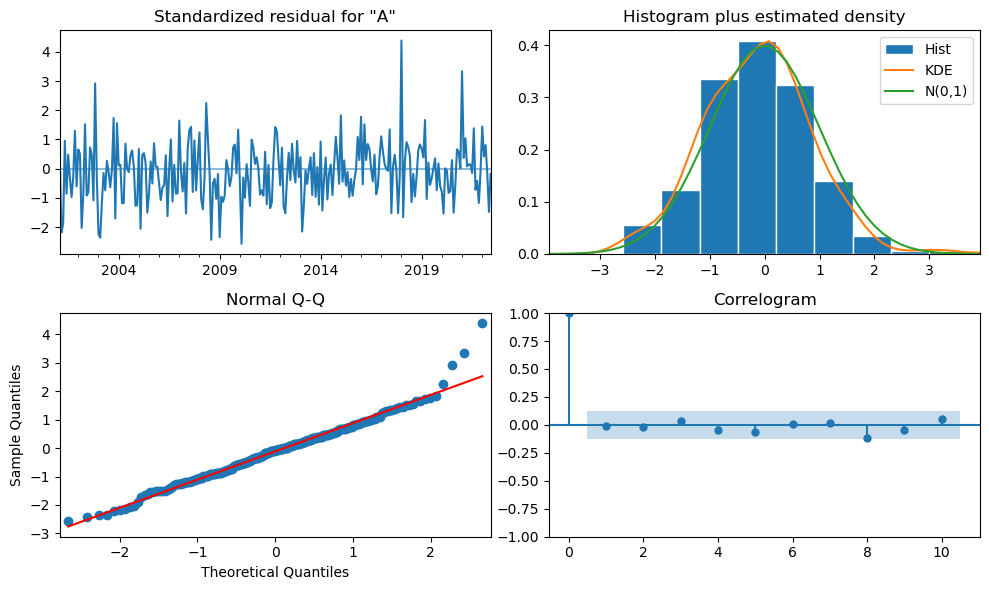

In [20]:
fig = assault_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 14.772
- MSE = 275.912
- RMSE = 16.611
- R^2 = -0.315
- MAPE = 2.16%


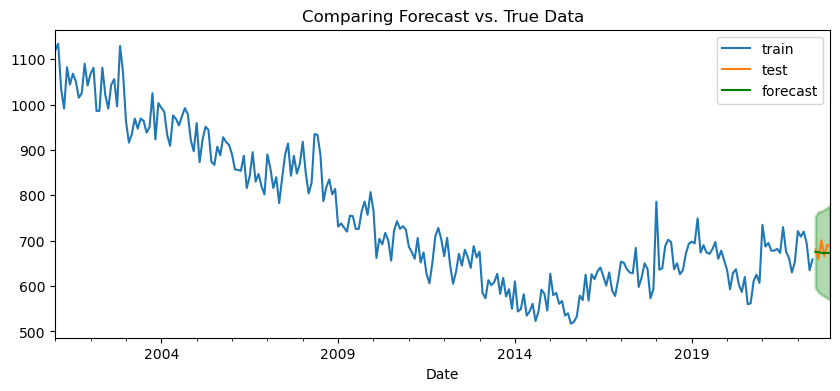

In [21]:
forecast_assault = assault_model.get_forecast(steps=len(test_assault)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train_assault, test_assault, forecast_assault);
# Obtain metrics
regression_metrics_ts(test_assault, forecast_assault['mean'])

In [22]:
assault_auto = pm.auto_arima(
    train_assault,
    seasonal=True,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2632.760, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2689.553, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2665.314, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2634.871, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2687.959, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2630.516, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2632.064, Time=0.26 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2631.938, Time=1.30 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2630.112, Time=0.43 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2630.748, Time=1.08 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2628.120, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2630.075, Time=0.22 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=2628.822, Time=0.70 sec
 ARIMA(1,1,2)(1,0,1)[12]

C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 17.429
- MSE = 420.593
- RMSE = 20.508
- R^2 = -1.005
- MAPE = 2.53%


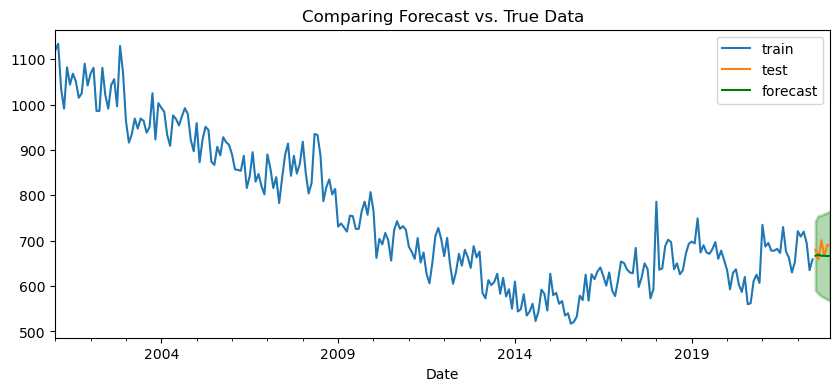

In [23]:
assault_auto = tsa.ARIMA(
    train_assault, order=assault_auto.order, seasonal_order=assault_auto.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
assault_forecast_df = assault_auto.get_forecast(steps=len(test_assault)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train_assault, test_assault, assault_forecast_df);
# Obtain metrics
regression_metrics_ts(test_assault, assault_forecast_df['mean'])

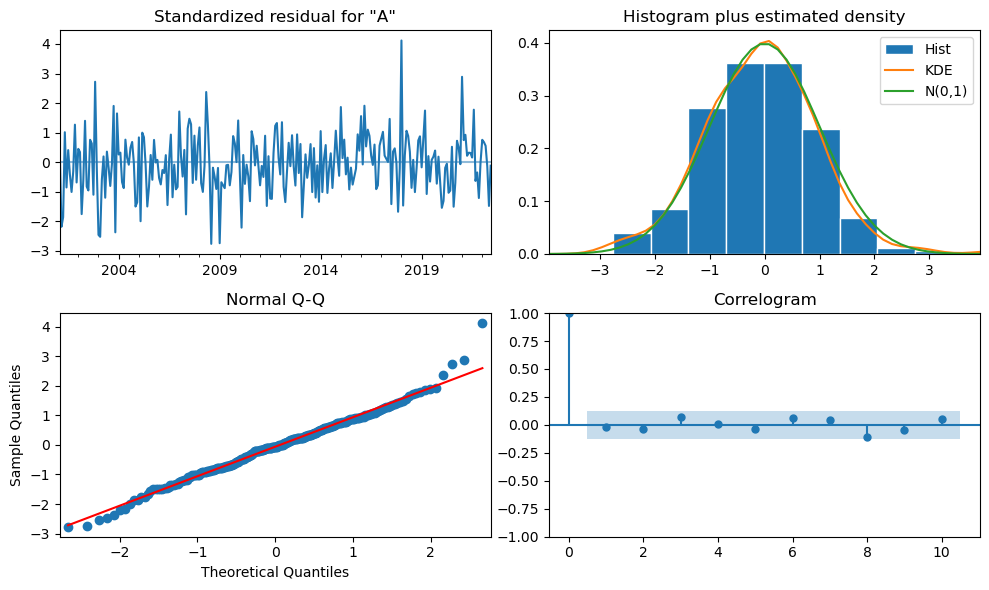

In [24]:
fig = assault_auto.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## Evaluation: 
For our assault data , the results of Regression Metrics of the first model are the best comparing with the auto_model .
so i should use the first model .

In [25]:
p=2
d=1
q=1
P=0
D=0
Q=0
m=12
final_assault_model = tsa.ARIMA(
    assault, order=(p,d,q), seasonal_order=(P,D,Q,m)
).fit()

C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


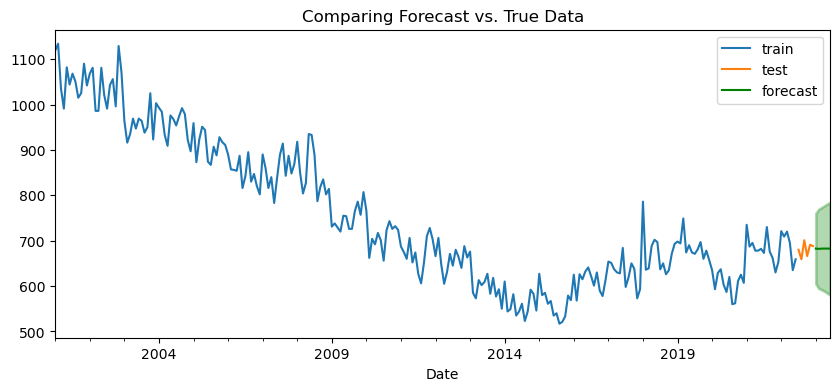

In [26]:
forecast_df  = final_assault_model.get_forecast(len(test_assault)).summary_frame()
plot_forecast(train_assault,test_assault,forecast_df);

In [27]:
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
change = final_value - starting_value
change 

0.014029270404535055

In [28]:
perc_change = (change / starting_value) * 100
perc_change

0.002055406125782819

Our model's forecast indicates that the number of assault will increase by about 0.002% but i really dont trust thoes forcast since our model dont perform that well .

# Theft

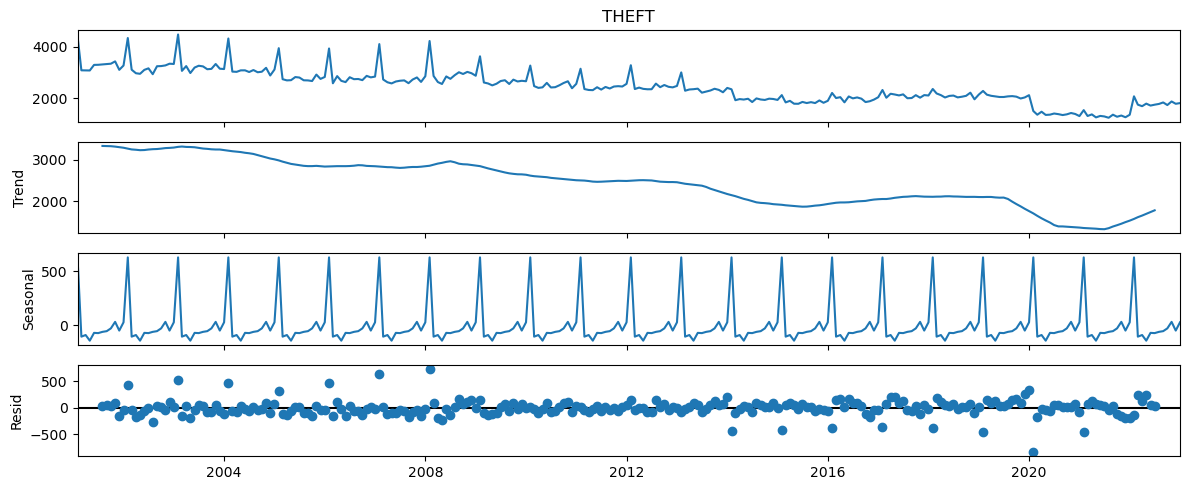

In [29]:
theft_decomp = tsa.seasonal_decompose(theft)
fig = theft_decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [30]:
theft_seasonal_delta = theft_decomp.seasonal.max() - theft_decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {theft_seasonal_delta} which is ~{theft_seasonal_delta/(theft.max()-theft.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 775.6706349206349 which is ~24.06% of the variation in time series.


In [31]:
d = ndiffs(theft)
D = nsdiffs(theft,m=12)
print (f'd = {d}')
print (f'D = {D}')

d = 1
D = 0


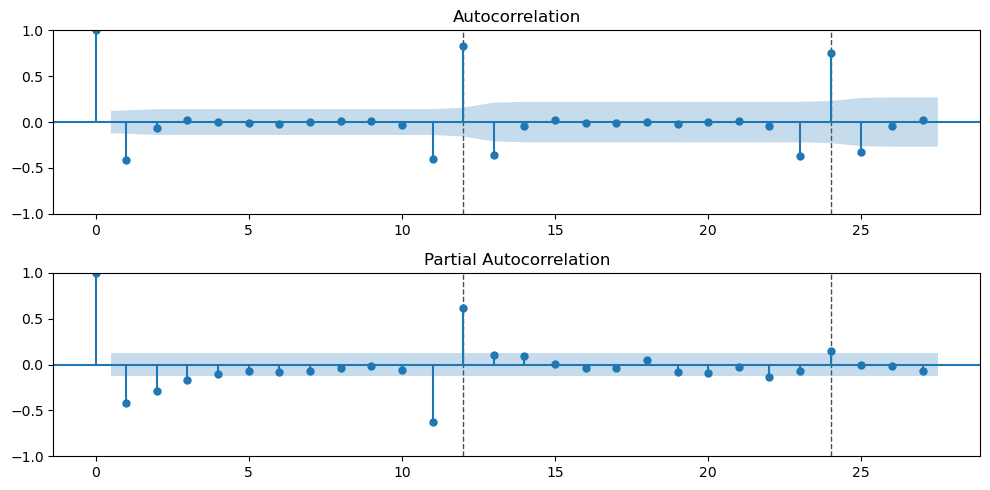

In [32]:
theft_diff = theft.diff().dropna()
plot_acf_pacf(theft_diff, annotate_seas=True, m = 12, nlags = 27);

the seasonal part represent 24.06% of the variation of the data .

ACF seems to drop after the first lag .

PACF seems to drop after the second lag .

let'Ss try ARMA((2,0,1,12)2,1,1)

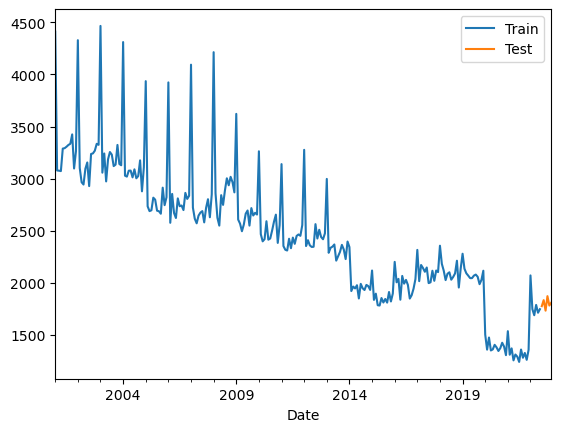

In [33]:
train_theft, test_theft = train_test_split(theft, test_size= 6)
ax = train_theft.plot(label='Train')
test_theft.plot(ax=ax, label='Test')
ax.legend();

In [34]:
p=1
d=1
q=1
P=2
D=0
Q=1
m=12
theft_model = tsa.ARIMA(
    train_theft, order=(p,d,q), seasonal_order=(P,D,Q,m)
).fit()
theft_model.summary()

C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            THEFT   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -1656.418
Date:                          Tue, 12 Mar 2024   AIC                           3324.837
Time:                                  19:43:31   BIC                           3346.131
Sample:                              01-31-2001   HQIC                          3333.400
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0429      0.032      1.353      0.176      -0.019       0.105
ma.L1         -0.5408      0.056     -9.633      0.000      -0.651      -0.431
ar.S.L12       1.7155      0.044     39.411      0.000       1.630       1.801
ar.S.L24      -0.7157      0.042    -17.045      0.000      -0.798      -0.633
ma.S.L12      -0.9811      0.067    -14.650      0.000      -1.112      -0.850
sigma2      2.146e+04   6.39e-06   3.36e+09      0.000    2.15e+04    2.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               448.82
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -1.05
Prob(H) (two-sided):                  0.28   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.33e+24. Standard errors may be unstable.
"""

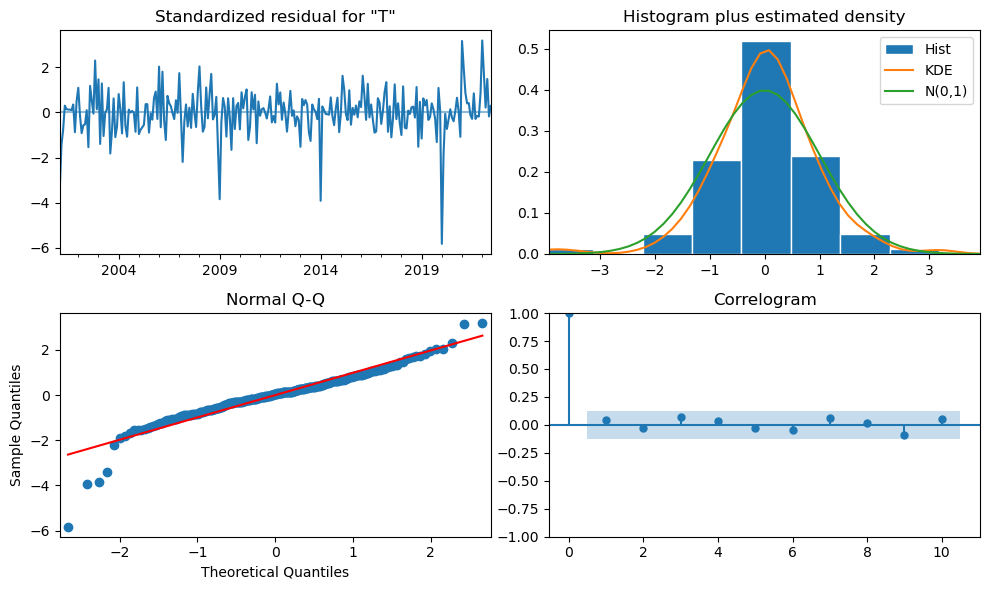

In [35]:
fig = theft_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 61.117
- MSE = 4,881.013
- RMSE = 69.864
- R^2 = -1.481
- MAPE = 3.37%


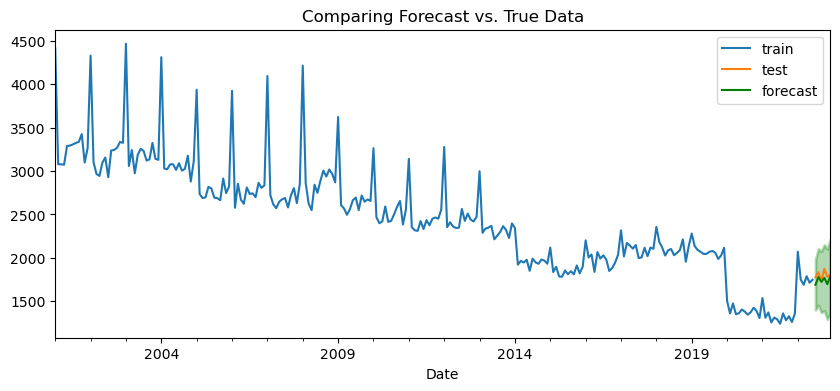

In [36]:
forecast_theft = theft_model.get_forecast(steps=len(test_theft)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train_theft, test_theft, forecast_theft);
# Obtain metrics
regression_metrics_ts(test_theft, forecast_theft['mean'])

In [37]:
theft_auto = pm.auto_arima(
    train_theft,
    seasonal=True,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3757.218, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3349.910, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3487.989, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3755.432, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3702.819, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3317.471, Time=0.59 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3525.537, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3317.617, Time=1.04 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3474.555, Time=0.42 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3349.737, Time=0.47 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 51.688
- MSE = 3,780.351
- RMSE = 61.485
- R^2 = -0.922
- MAPE = 2.83%


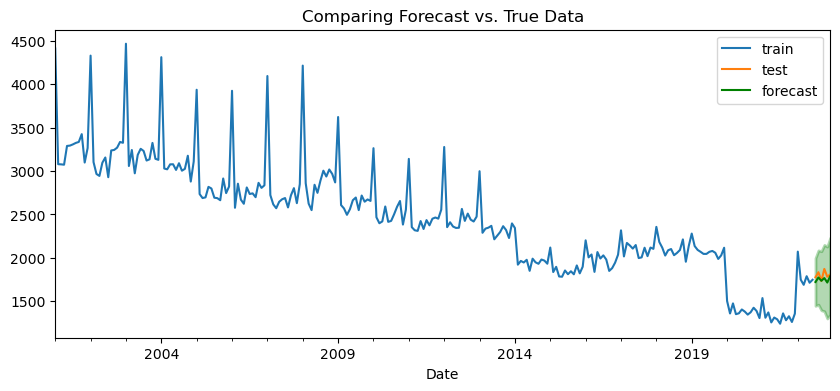

In [38]:
theft_auto = tsa.ARIMA(
    train_theft, order=theft_auto.order, seasonal_order=theft_auto.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
theft_forecast_df = theft_auto.get_forecast(steps=len(test_theft)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train_theft, test_theft, theft_forecast_df);
# Obtain metrics
regression_metrics_ts(test_theft, theft_forecast_df['mean'])

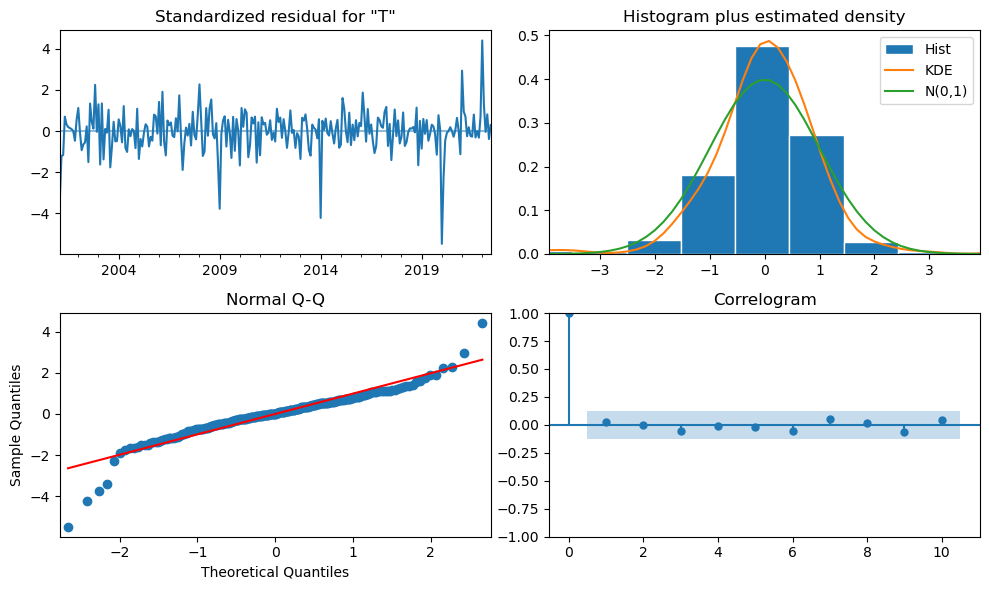

In [39]:
fig = theft_auto.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## Evaluation: 
For our assault data , the results of Regression Metrics of the auto model are the best comparing with the first model .
so i should use the auto model .

In [40]:
p=2
d=1
q=0
P=1
D=0
Q=2
m=12
final_theft_model = tsa.ARIMA(
    theft, order=(p,d,q), seasonal_order=(P,D,Q,m)
).fit()

C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\aziz\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


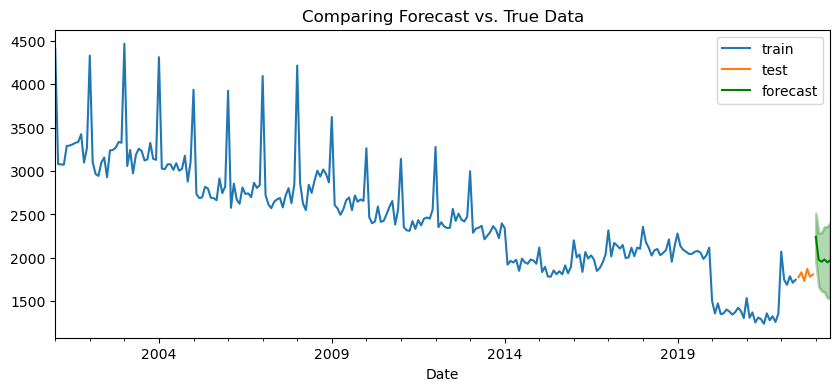

In [41]:
forecast_df  = final_theft_model.get_forecast(len(test_theft)).summary_frame()
plot_forecast(train_theft,test_theft,forecast_df);

In [42]:
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
change = final_value - starting_value
change 

-271.8180720324963

In [43]:
perc_change = (change / starting_value) * 100
perc_change

-12.121227695001293

Our model's forecast indicates that the number of theft will decrease by about 12 % .

# Final Evaluation:

- Theft have the highest monthly count of crimes at the end of the forecast.

- Assault have the highest net change by the end of the forecast.

- Assault have the highest percent change by the end of the forecast.

# Final Recommendations :
What recommendation would you make to the stakeholders

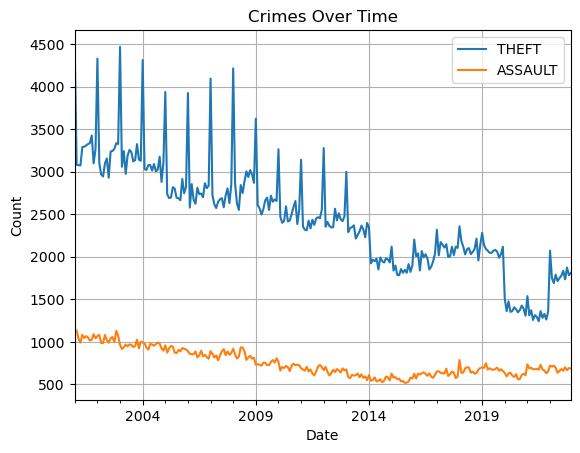

In [47]:
ax = theft.plot()
assault.plot(ax=ax)
ax.set(ylabel="Count", xlabel="Date", title="Crimes Over Time");
plt.grid()
plt.legend()

Since the theft is the crime with the most count comparing to assault , i recommand to continue to keep an eye on those even if our model suggested that they will have a decrease in the next 6 months . 
For the assault the model predicted that it will have a small increase in the count . 